In [1]:
import numpy as np
import matplotlib.pyplot as plt
import frgtools.misc as frgm

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Load Data

In [2]:
fids = frgm.listdir('data', display=True)

Files in 'data':
0:500nm sp + psk.SSM
1:psk_absorbance.ABS
2:no sp transmission.TRM
3:500nm sp.SSM
4:500nm sp transmission.TRM
5:500nm sp + psk transmission.TRM
6:no sp signal.SSM


In [3]:
lamp_spectrum = np.loadtxt(fids[6], skiprows=2)[:,1]
wl = np.loadtxt(fids[4], skiprows=2)[:,0]
lamp_sp = np.loadtxt(fids[4], skiprows=2)[:,1]

pl_blank = np.loadtxt(fids[3], skiprows=2)[:,1]
pl_psk = np.loadtxt(fids[0], skiprows=2)[:,1]

a_psk = np.loadtxt(fids[1], skiprows=2)[:,1]

# Raw Lamp Spectrum

There is a correction filter installed by default, with the goal of balancing blue and red wavelengths better. Even with this in, the <500 nm region of the spectrum is really dim

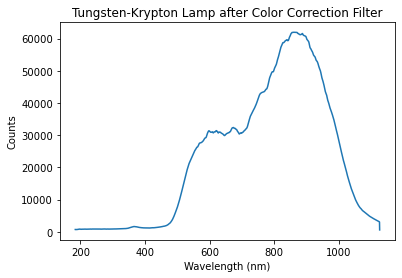

In [4]:
plt.plot(wl, lamp_spectrum)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.title('Tungsten-Krypton Lamp after Color Correction Filter')
plt.show()

# Absorbance

The dimness of lower wavelenghts really shows in the absorbance data.

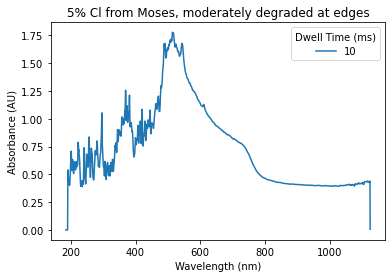

In [5]:
plt.plot(wl, a_psk, label = 10)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (AU)')
plt.title('5% Cl from Moses, moderately degraded at edges')
plt.legend(title='Dwell Time (ms)')
plt.show()

We can stack a series of measurements at different dwell times and determine which wavelengths to analyze at each point - basically HDR spectroscopy

In [6]:
import pickle
with open("PSK Transmission HDR_2.pkl", 'rb') as f:
    hdr = pickle.load(f)

In [7]:
dwells = hdr['dwells']
wlhdr = hdr['wl']
light = np.stack(hdr['light_bl'])[:,:,1]
dark = np.stack(hdr['dark_bl'])[:,:,1]
psk = np.stack(hdr['psk'])[:,:,1]

In [8]:
lightmask = light<=65000

In [9]:
whichidx = lightmask.shape[0]-np.argmax(lightmask[::-1], axis=0)

In [10]:
from matplotlib import colors

cmap = colors.ListedColormap([plt.cm.tab10(i) for i in range(whichidx.max())])

Incident (100% Transmission) spectrum at multiple dwell times

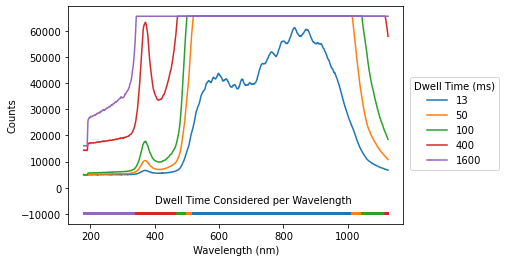

In [11]:
for d, l in zip(dwells, light):
    plt.plot(wlhdr, l, label=d)

plt.scatter(wlhdr, np.full(wlhdr.shape, -10000), c=whichidx, cmap=cmap, s=10, marker='|')
plt.legend(title='Dwell Time (ms)', bbox_to_anchor=(0.8,0.2,0.5,0.5))
plt.text(
    s='Dwell Time Considered per Wavelength',
    x=400,
    y=-6000
)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.show()

In [12]:
t = (psk-dark)/(light-dark)
# t = psk/light

In [13]:
t.shape

(5, 2048)

In [14]:
t_hdr = np.array([t_[i-1] for t_, i in zip(t.T, whichidx)])
a_hdr = -np.log(t_hdr)

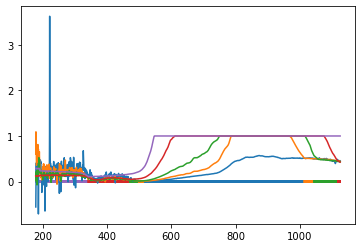

In [15]:
for d, l in zip(dwells, t):
    plt.plot(wlhdr, l, label=d)

plt.scatter(wlhdr, np.zeros(wlhdr.shape), c=whichidx, cmap=cmap, s=10, marker='|')
plt.show()

Text(0.5, 1.0, 'Moderately Degraded 5% Cl Film from Moses')

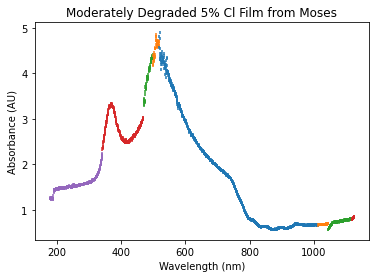

In [16]:
# plt.plot(wlhdr, t_hdr)
# plt.plot(wlhdr, -np.log(t_hdr))
plt.scatter(wlhdr, a_hdr, c=whichidx, cmap=cmap, s=10, marker='|')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (AU)')
plt.title('Moderately Degraded 5% Cl Film from Moses')

In [17]:
lambdadata = np.loadtxt('Cl_5_T.Sample.Raw.csv', skiprows=2, delimiter=',')

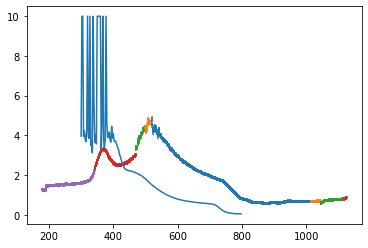

In [18]:
plt.plot(lambdadata[:,0], lambdadata[:,1])
plt.scatter(wlhdr, a_hdr, c=whichidx, cmap=cmap, s=10, marker='|')

In [19]:
import frgtools.uvvis as uvt

In [20]:
help(uvt.tauc)

Help on function tauc in module frgtools.uvvis:

tauc(wl, a, bandgap_type, wlmin=None, wlmax=None, fit_width=None, fit_threshold=0.1, plot=False, verbose=False)
    Performs Tauc plotting analysis to determine optical bandgap from absorbance data
    Plots data in tauc units, then performs linear fits in a moving window to find the
    best linear region. this best fit line is extrapolated to the x-axis, which corresponds
    to the bandgap.
    
    inputs
    
            wl: array of wavelengths (nm)
            a: absorption coefficient. Absorbance can also be used - while the plot will be stretched in y, a scalar factor here doesnt affect the bandgap approximation
            thickness: sample thickness (cm)
            bandgap_type: ['direct', 'indirect']. determines coefficient on tauc value
    
            wlmin: minimum wavelength (nm) to include in plot
            wlmax: maximum wavelenght (nm) to include in plot
            fit_width: width of linear fit window, in units o

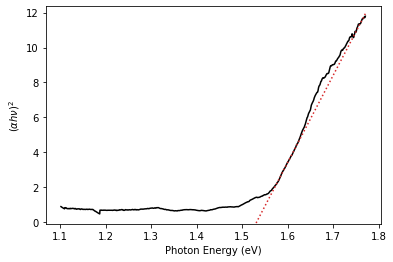

1.531853599988335

In [21]:
uvt.tauc(wlhdr, a_hdr, 'direct', wlmin=700, plot=True)

# PL with the Lamp + 500nm Shortpass as Excitation Source

In [21]:
t_psk = np.exp(-a_psk)

In [22]:
pl_psk_corrected = pl_psk / t_psk

The 500 nm shortpass does a good job up to 700 nm, after which some sort of interference in the filter allows a lot of light through. The PL spectrum is swamped somewhere in that pattern. 

The transmission makes it impossible to dwell for the length of time necessary to see our luminescence (this is with a 10 ms dwell - the glovebox data is often 1000 ms dwell, and with a (I think) brighter source to boot)

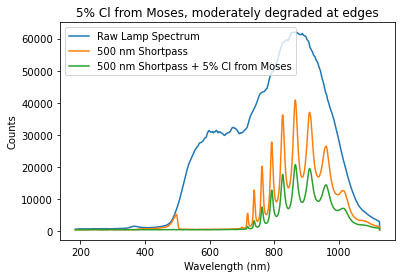

In [72]:
plt.plot(wl, lamp_spectrum, label='Raw Lamp Spectrum')
plt.plot(wl, pl_blank, label='500 nm Shortpass')
plt.plot(wl, pl_psk, label='500 nm Shortpass + 5% Cl from Moses')

plt.legend()
plt.title('5% Cl from Moses, moderately degraded at edges')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.show()

In [40]:
wlidx = np.argmin(np.abs(wl-900))

In [55]:
# t_psk = np.exp(-a_psk)
t_psk = 10**-a_psk
pl_psk_corrected = pl_psk / t_psk
# offset = pl_blank[wlidx]/pl_psk_corrected[wlidx]
# pl_psk_corrected *= offset

I tried correcting the PL spectrum by the absorbance plot above, but there is still discrepancy

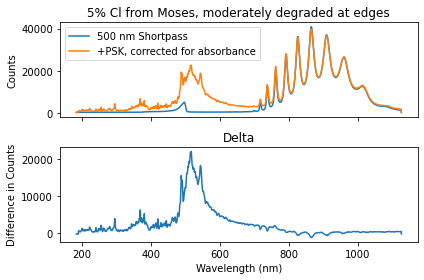

In [73]:
fig, ax = plt.subplots(2,1, sharex=True)
plt.sca(ax[0])
plt.plot(wl, pl_blank, label='500 nm Shortpass')
plt.plot(wl, pl_psk_corrected, label='+PSK, corrected for absorbance')

plt.legend()
plt.title('5% Cl from Moses, moderately degraded at edges')
# plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')

plt.sca(ax[1])
plt.plot(wl, pl_psk_corrected - pl_blank)

plt.title('Delta')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Difference in Counts')

plt.tight_layout()
plt.show()

In [70]:
# t_psk = np.exp(-a_psk)
t_psk = 10**-a_psk
pl_psk_corrected = pl_psk / t_psk
offset = pl_blank[wlidx]/pl_psk_corrected[wlidx]
pl_psk_corrected *= offset

Further correcting the data (account for absorbance, then scale to match counts at 900 nm (past the absorption onset), still no apparent PL 

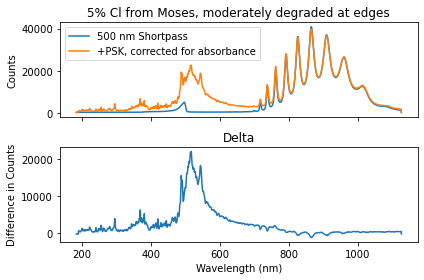

In [71]:
fig, ax = plt.subplots(2,1, sharex=True)
plt.sca(ax[0])
plt.plot(wl, pl_blank, label='500 nm Shortpass')
plt.plot(wl, pl_psk_corrected, label='+PSK, corrected for absorbance')

plt.legend()
plt.title('5% Cl from Moses, moderately degraded at edges')
# plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')

plt.sca(ax[1])
plt.plot(wl, pl_psk_corrected - pl_blank)

plt.title('Delta')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Difference in Counts')

plt.tight_layout()

# Thorlabs Temperature Filter for Lamp Color Correction

We could possibly improve the bluer side of absorbance data with a color temperature filter. Thorlabs has two options - our expected lamp spectrum with these filters is shown below

Load thorlabs reference spectra

In [84]:
import pandas as pd
df = pd.read_excel("SLS201L_Temperature_Balancing.xlsx", skiprows=2)

In [94]:
wl2 = df[df.columns[2]].values
nofilter = df[df.columns[3]].values
filter132 = df[df.columns[4]].values
filter160 = df[df.columns[5]].values

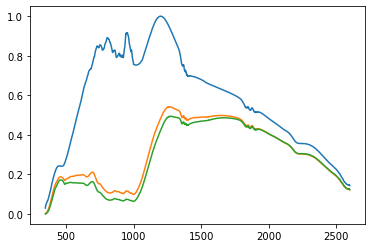

In [95]:
plt.plot(wl2, nofilter, label='nofilter')
plt.plot(wl2, filter132, label='-132')
plt.plot(wl2, filter160, label='-160')

In [96]:
t_132 = filter132/nofilter
t_160 = filter160/nofilter

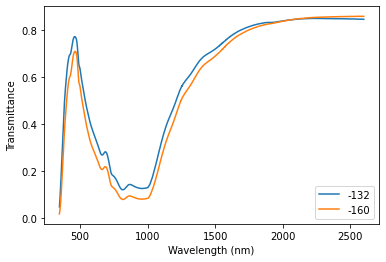

In [98]:
plt.plot(wl2, t_132, label='-132')
plt.plot(wl2, t_160, label='-160')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance')
plt.legend()

Approximate the stellarnet lamp spectrum with these filters

In [108]:
lamp_spectrum_132 = lamp_spectrum * np.interp(wl, wl2, t_132)
lamp_spectrum_132_132 = lamp_spectrum * np.interp(wl, wl2, t_132)**2
lamp_spectrum_160 = lamp_spectrum * np.interp(wl, wl2, t_160)
lamp_spectrum_160_160 = lamp_spectrum * np.interp(wl, wl2, t_160)**2

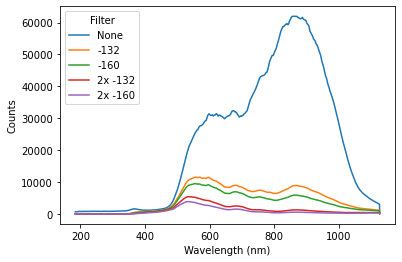

In [109]:
plt.plot(wl, lamp_spectrum, label='None')
plt.plot(wl, lamp_spectrum_132, label='-132')
plt.plot(wl, lamp_spectrum_160, label='-160')
plt.plot(wl, lamp_spectrum_132_132, label='2x -132')
plt.plot(wl, lamp_spectrum_160_160, label='2x -160')
plt.legend(title='Filter')
plt.ylabel('Counts')
plt.xlabel('Wavelength (nm)')
plt.show()

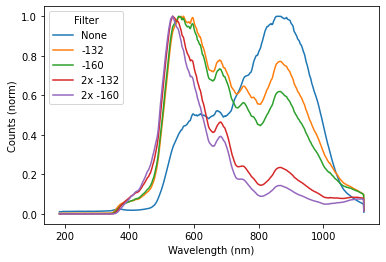

In [110]:
plt.plot(wl, lamp_spectrum/lamp_spectrum.max(), label='None')
plt.plot(wl, lamp_spectrum_132/lamp_spectrum_132.max(), label='-132')
plt.plot(wl, lamp_spectrum_160/lamp_spectrum_160.max(), label='-160')
plt.plot(wl, lamp_spectrum_132_132/lamp_spectrum_132_132.max(), label='2x -132')
plt.plot(wl, lamp_spectrum_160_160/lamp_spectrum_160_160.max(), label='2x -160')
plt.legend(title='Filter')
plt.ylabel('Counts (norm)')
plt.xlabel('Wavelength (nm)')
plt.show()